In [1]:
%matplotlib inline 
import torch 
import torch.nn as nn
import torch.distributions as D
import numpy as np
import matplotlib.pyplot as plt

from pyvi.utils import GMMLossFunc as lf
from pyvi.utils import HelperFunc as hf


device = ("cuda" if torch.cuda.is_available()
          else "mps" if torch.backends.mps.is_available()
          else "cpu")

print(f"Using {device} device")

plt.style.use('fivethirtyeight')
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})


Using cuda device


#  AR(1) state-space model

We consider a AR(1) state process:
\begin{align*}
    y_t|x_t &\sim  \mathcal{N}(\rho_0 + x_t, \sigma_y^2), \quad t=1,\dots, T; \\
    x_t|x_{t-1} &\sim \mathcal{N}(\rho_1 x_{t-1}, \sigma_x^2),\quad t=1,\dots, T;\\
    x_0 &\sim  \mathcal{N}(0, \sigma_{x}^2)
\end{align*}

The model parameters are $\mathbf{\theta} = (\rho_0, \rho_1, \sigma_x^2, \sigma_y^2)$. We'll start by ignoring the observation noise, i.e we assume $y_t = x_t$ for all $t$.

## 1. Simulator

In [2]:
# simulator
def AR1(theta: torch.Tensor, T=100) -> torch.Tensor:
    '''
    Simulates from an AR(1) process. 

    Input: theta = [rho_0, rho_1, sigma2_x]
    '''
    x = torch.zeros((theta.size(0), (T + 1)))
    # simulate x0
    x[...,0] = D.Normal(loc=0., scale=torch.sqrt(theta[...,2])).sample()
    
    for t in range(1,T+1):
        x[...,t] =  D.Normal(theta[...,1] * x[...,t-1], torch.sqrt(theta[...,2])).sample() 
    
    # simulate observations
    y = D.Normal(theta[...,0] + x.T, torch.sqrt(theta[...,3])).sample()

    return y.T


### simulation

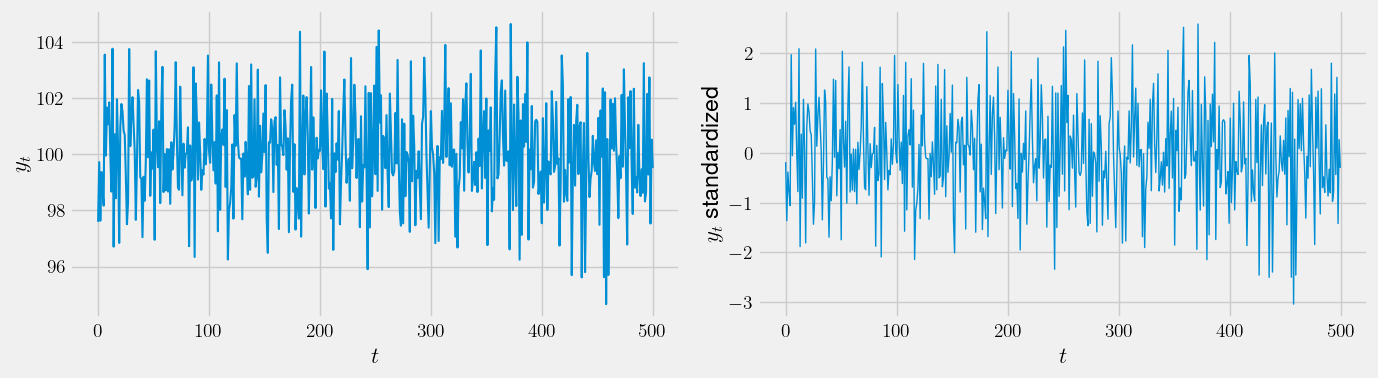

In [3]:
theta = torch.tensor([[100., -0.3, 2.0, 1.0]])
T = 500

y = AR1(theta, T).squeeze()

fig = plt.figure(figsize=(14,4))

fig.add_subplot(121)
plt.plot(torch.arange(T+1), y, lw=1.5)
plt.xlabel(r'$t$')
plt.ylabel(r'$y_t$')

fig.add_subplot(122)
plt.plot(torch.arange(T), (y[1:] - y.mean()) / y.std(), lw=1)
plt.xlabel(r'$t$')
plt.ylabel(r'$y_t$ standardized')

plt.tight_layout()
plt.show()

# 2. Parameter priors

\begin{align*}
    \rho_0 &\sim \mathcal{N}(0,10),\\
    \rho_1 &\sim \mathrm{Uniform}(0,1),\\
    \sigma_{x}^2 &\sim \Gamma^{-1}(2, 4)
\end{align*}

In [4]:
class GaussianInverseGamma():
    def __init__(self, params_rho0, params_rho1, params_sigma2_x, params_sigma2_y):
        
        self.rho0 = D.Normal(params_rho0['mean'], params_rho0['sigma'])
        
        self.logitrho1 = D.Normal(params_rho1['mean'], params_rho1['sigma'])

        self.sigma2_x = D.InverseGamma(params_sigma2_x['alpha'], params_sigma2_x['beta'])

        self.sigma2_y = D.InverseGamma(params_sigma2_y['alpha'], params_sigma2_y['beta'])
        
        
    def sample(self, shape: torch.Size = ()):
        theta = torch.stack([self.rho0.sample(shape),
                            self.logitrho1.sample(shape),
                            self.sigma2_x.sample(shape),
                            self.sigma2_y.sample(shape)
                            ], dim=-1)  
        # fully tranformed scale
        theta_transformed = theta.clone()
        theta_transformed[...,2:] = theta_transformed[...,2:].log()

        # natural scale
        theta[...,1] = (theta[...,1].exp() - 1) / (theta[...,1].exp() + 1)

        return theta, theta_transformed

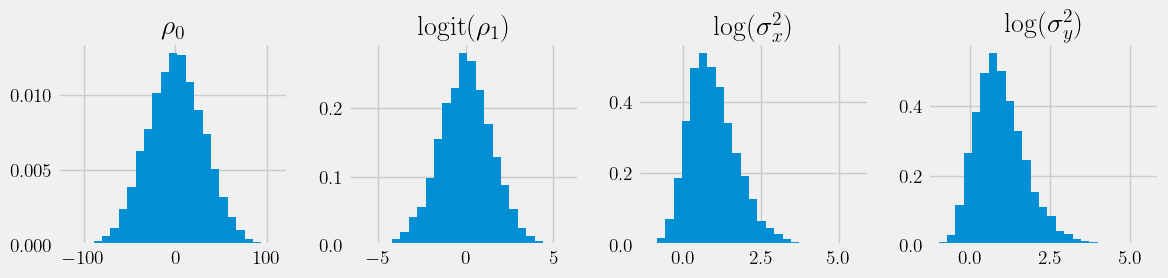

In [10]:
rho0 = {'mean': 0.0, 'sigma': 0.001**(-0.5)}
logitrho1 = {'mean': 0.0, 'sigma': 1.5}
sigma2_x = {'alpha': 1.0, 'beta': 1.0}
sigma2_y = {'alpha': 2.0, 'beta': 4.0}

prior = GaussianInverseGamma(rho0, logitrho1, sigma2_x, sigma2_y)

N = 10000
theta, theta_transformed =  prior.sample((N,))

fig = plt.figure(figsize=(12, 3))

fig.add_subplot(141)
plt.hist(theta_transformed[...,0], bins=25, density=True)
plt.title(r'$\rho_0$')

fig.add_subplot(142)
plt.hist(theta_transformed[...,1], bins=25, density=True)
plt.title(r'$\mathrm{logit}(\rho_1)$')

fig.add_subplot(143)
plt.hist(theta_transformed[...,2], bins=25, density=True)
plt.title(r'$\log(\sigma_{x}^2) $')

fig.add_subplot(144)
plt.hist(theta_transformed[...,3], bins=25, density=True)
plt.title(r'$\log(\sigma_{y}^2) $')

plt.tight_layout()
plt.show()

## 3. Neural Varitional inference: Training the Neural Net

In [6]:
class MultivariateGaussianMDN(nn.Module):
    '''
        Multivariate Gaussian Mixture Density Network class for amortized variational inference

        Gaussian mixtures are dense in the space of probability distributions. This motivates their use for posterior density approximation.

        Each mixture is parameterized by the means, Cholesky factors of associated precision matrices and mixture weights.

        The neural network does not output the Cholesky factors directly but rather tensors containing their respective lower diagonal elements.

    '''
    def __init__(self, input_size:int, dim:int=2, K:int=1, hd:int=64, sort=False):
        '''
            Input: 
                * input_size: dimension of the input to the neural net, i.e. the number of elements in the observation vector yobs
                * dim:        dimension of the posterior distribution. This is in general the number of parameters in the model.
                * K:          number of mixture components
                * hd:     dimension of hidden layers
            Output:
                * mean: tensor of dimensions batchsize X k X dim containing the predicted means
                * chol: tensor of appropriate dimensions containing the the predicted Cholesky factors
                * coeff: tensor of appropriate dimensions containing the predicted mixture component weights
        '''
        super().__init__()

        self.dim = dim
        self.K = K
        self.hd = hd
        self.sort = sort

        self.hidden = nn.Sequential(          # hidden layers
            #nn.LayerNorm(input_size),
            nn.Linear(input_size, self.hd),
            nn.ReLU(),
            nn.LayerNorm(self.hd),
            nn.Linear(self.hd, self.hd),
            nn.ReLU(),
            nn.LayerNorm(self.hd),
            nn.Linear(self.hd, self.hd),
            nn.ReLU(),
            nn.LayerNorm(self.hd),
            nn.Linear(self.hd, self.hd),
            nn.ReLU(),
            nn.LayerNorm(self.hd)
        )
        
        # means of each component
        self.mean = nn.Linear(self.hd, self.K * self.dim)
        
        # Cholesky factors of the precision matrices (diagonal elements are log-scaled)
        self.chol = nn.Linear(self.hd, self.K * self.dim * (self.dim + 1) // 2)

        # mixture weights, non-negative and summing to 1
        self.coeff = nn.Sequential(
            nn.Linear(self.hd, self.K),
            nn.Softmax(dim=1)   
            )          
    
    def forward(self, x):
        if self.sort:
            x = x.sort().values

        x = self.hidden(x)
        # mean
        mean = self.mean(x)
        mean = mean.reshape((mean.shape[0], self.K, self.dim))

        # Cholecky factor
        chol = self.chol(x)
        chol = chol.reshape((chol.shape[0], self.K, self.dim * (self.dim + 1) // 2))

        # mixture weights
        if self.K > 1:
            coeff = self.coeff(x)
        else:
            coeff = torch.ones(1)
        
        return mean, chol, coeff
    

class ConvNet(nn.Module):
     '''
        Multivariate Gaussian Mixture Density Network class for amortized variational inference

        Gaussian mixtures are dense in the space of probability distributions. This motivates their use for posterior density approximation.

        Each mixture is parameterized by the means, Cholesky factors of associated precision matrices and mixture weights.

        The neural network does not output the Cholesky factors directly but rather tensors containing their respective lower diagonal elements.
    '''
     def __init__(self, input_size, dim:int=2, K:int=1, hd:int=64):
        '''
            Input: 
                * input_size: dimension of the input to the neural net, i.e. the number of elements in the observation vector yobs
                * dim:        dimension of the posterior distribution. This is in general the number of parameters in the model.
                * K:          number of mixture components
                * hd:     dimension of hidden layers
            Output:
                * mean: tensor of dimensions batchsize X k X dim containing the predicted means
                * chol: tensor of appropriate dimensions containing the the predicted Cholesky factors
                * coeff: tensor of appropriate dimensions containing the predicted mixture component weights
        '''
        super().__init__()

        self.dim = dim
        self.K = K
        self.hd = hd
        self.input_size = input_size 


        # convolutional layers
        self.conv = nn.Sequential(
            nn.LayerNorm(self.input_size),
            nn.Conv1d(1, 1, 5, padding='same'),
            nn.ReLU(),
            nn.MaxPool1d(4),
            #nn.LayerNorm(self.input_size // 4),
            nn.Conv1d(1, 1, 5, padding='same'),
            nn.ReLU(),
            nn.MaxPool1d(2)#,
            #nn.LayerNorm(self.input_size // 8)
        )

        # fully connected (((self.input_size - 4) // 3) - 4) // 2layers
        self.fc = nn.Sequential(
            nn.Linear(self.input_size // 8, self.hd),
            nn.ReLU()#,
            # nn.Linear(self.hd, self.hd),
            # nn.ELU()
        )
        
        # means of each component
        self.mean = nn.Linear(self.hd, self.K * self.dim)
        
        # Cholesky factors of the precision matrices (diagonal elements are log-scaled)
        self.chol = nn.Linear(self.hd, self.K * self.dim * (self.dim + 1) // 2)

        # mixture weights, non-negative and summing to 1
        self.coeff = nn.Sequential(
            nn.Linear(self.hd, self.K),
            nn.Softmax(dim=1)   
            )  

        
     def forward(self, x):
        # apply convolutional layers
        x = self.conv(x)
        # flatten
        x = x.flatten(1)
        # apply fully-connected layers
        x = self.fc(x)

        # mean
        mean = self.mean(x)
        mean = mean.reshape((mean.shape[0], self.K, self.dim))

        # Cholecky factor
        chol = self.chol(x)
        chol = chol.reshape((chol.shape[0], self.K, self.dim * (self.dim + 1) // 2))

        # mixture weights
        if self.K > 1:
            coeff = self.coeff(x)
        else:
            coeff = torch.ones(1)
        
        return mean, chol, coeff


class LSTMNet(nn.Module):
     '''
        Multivariate Gaussian Mixture Density Network class for amortized variational inference

        Gaussian mixtures are dense in the space of probability distributions. This motivates their use for posterior density approximation.

        Each mixture is parameterized by the means, Cholesky factors of associated precision matrices and mixture weights.

        The neural network does not output the Cholesky factors directly but rather tensors containing their respective lower diagonal elements.
    '''
     def __init__(self, input_size, dim:int=2, K:int=1, hd:int=64):
        '''
            Input: 
                * input_size: dimension of the input to the neural net, i.e. the number of elements in the observation vector yobs
                * dim:        dimension of the posterior distribution. This is in general the number of parameters in the model.
                * K:          number of mixture components
                * hd:     dimension of hidden layers
            Output:
                * mean: tensor of dimensions batchsize X k X dim containing the predicted means
                * chol: tensor of appropriate dimensions containing the the predicted Cholesky factors
                * coeff: tensor of appropriate dimensions containing the predicted mixture component weights
        '''
        super().__init__()

        self.dim = dim
        self.K = K
        self.hd = hd
        self.input_size = input_size 

        # normalizing layer
        self.norm = nn.LayerNorm(self.input_size)

        # lstm layer
        self.lstm = nn.LSTM(input_size=self.input_size, hidden_size=self.hd, num_layers=2, batch_first=True)

        # fully connected hidden layer
        self.fc = nn.Sequential(
            nn.Linear(self.hd, self.hd),
            nn.ELU()
        )
        
        # means of each component
        self.mean = nn.Linear(self.hd, self.K * self.dim)
        
        # Cholesky factors of the precision matrices (diagonal elements are log-scaled)
        self.chol = nn.Linear(self.hd, self.K * self.dim * (self.dim + 1) // 2)

        # mixture weights, non-negative and summing to 1
        self.coeff = nn.Sequential(
            nn.Linear(self.hd, self.K),
            nn.Softmax(dim=1)   
            )  

        
     def forward(self, x):         
        # lstm & hidden layers
        x, _ = self.lstm(x)
        x = x[:,-1,:]   # extract final time step
        x = self.fc(x)

        # mean
        mean = self.mean(x)
        mean = mean.reshape((mean.shape[0], self.K, self.dim))

        # Cholecky factor
        chol = self.chol(x)
        chol = chol.reshape((chol.shape[0], self.K, self.dim * (self.dim + 1) // 2))

        # mixture weights
        if self.K > 1:
            coeff = self.coeff(x)
        else:
            coeff = torch.ones(1)
        
        return mean, chol, coeff
        
    


### Training

In [7]:
def transform_data(data, period_length):
    dataset = data.clone()
    dataset[...,1:] = data[...,1:] - data[...,:-1]
    #dataset = (dataset - dataset.mean(dim=0).unsqueeze(1)) / dataset.std(dim=-1).unsqueeze(1)
    Y = []

    for i in range(dataset.size(1) // period_length):
        period = dataset[...,i*period_length:(i*period_length + period_length)]
        Y.append(period)
    
    return torch.stack(Y, dim=1)

Epoch 1 Loss 5.0698884582519534 

Epoch 2 Loss 3.8036434555053713 

Epoch 3 Loss 3.416681160926819 

Epoch 4 Loss 3.138561661243439 

Epoch 5 Loss 2.933061966896057 

Epoch 6 Loss 2.779827778339386 

Epoch 7 Loss 2.6537584829330445 

Epoch 8 Loss 2.5950708103179934 

Epoch 9 Loss 2.4753355479240415 

Epoch 10 Loss 2.436170346736908 

Epoch 11 Loss 2.345701763629913 

Epoch 12 Loss 2.268010195493698 

Epoch 13 Loss 2.2358799028396605 

Epoch 14 Loss 2.1720891797542574 

Epoch 15 Loss 2.125152277946472 

Epoch 16 Loss 2.0794193625450133 

Epoch 17 Loss 2.040700010061264 

Epoch 18 Loss 1.9834800899028777 

Epoch 19 Loss 1.9132563591003418 

Epoch 20 Loss 1.8849756586551667 

Epoch 21 Loss 1.8960364699363708 

Epoch 22 Loss 1.8321586430072785 

Epoch 23 Loss 1.7698797905445098 

Epoch 24 Loss 1.7536161100864411 

Epoch 25 Loss 1.8277415657043456 

Epoch 26 Loss 1.7095101821422576 

Epoch 27 Loss 1.674855852127075 

Epoch 28 Loss 1.5895483326911926 

Epoch 29 Loss 1.6018637835979461 

Epoc

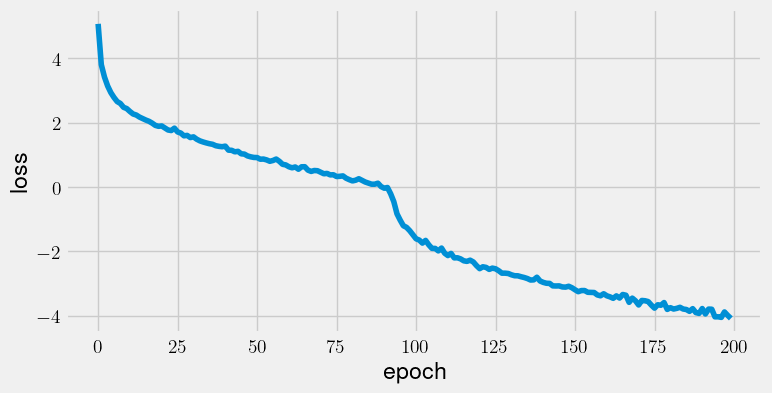

In [23]:
#Explicitly provided seeds for training process
random_seed = 12345
torch.manual_seed(random_seed)

cuda = torch.cuda.is_available()
if cuda:
    torch.cuda.manual_seed(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)

#========================================== 
#           generating training data
#==========================================
n_prior, n_obs, period_length, batchsize = 10000, 600, 30, 100

# sample parameter values from the specified prior
Theta_train, Theta_tranformed_train =  prior.sample((n_prior,))

# standardize alpha
mean_param, std_param =  Theta_tranformed_train.mean(dim=0), Theta_tranformed_train.std(dim=0)
Theta_tranformed_train = (Theta_tranformed_train - mean_param) / std_param

# draw samples from the simulator conditioned on parameter values
Y_train = AR1(Theta_train, n_obs-1)
Y_train = transform_data(Y_train, period_length=period_length)

# create a combined dataset and data loader
data_train = torch.utils.data.TensorDataset(Y_train, Theta_tranformed_train)
data_loader = torch.utils.data.dataloader.DataLoader(data_train, batch_size=batchsize, shuffle=True)

# Neural net
gmmnet = LSTMNet(input_size=period_length, dim=4, K=1, hd=64).to(device)
loss_fn = lf.GaussianMixtureLoss(aggr='mean')

# # train DNN model
gmmnet = hf.nn_optimizer(model=gmmnet, 
                       data_loader=data_loader,
                       loss_fn=loss_fn,
                       learning_rate=1e-3,
                       eps=0.001, #0.023, 
                       max_epochs=200,
                       verbose=True,
                       echo_after=1,
                       path='trained_models/ar/ar_lstm_2.pt'
                      )

#gmmnet = torch.load('trained_models/ar/ar_lstm_1.pt')

## 4. Posterior distribution

In [24]:
labels = [r'$\rho_0$', r'$\mathrm{logit}(\rho_1)$', r'$\log(\sigma_{x}^2) $', r'$\log(\sigma_{y}^2) $']

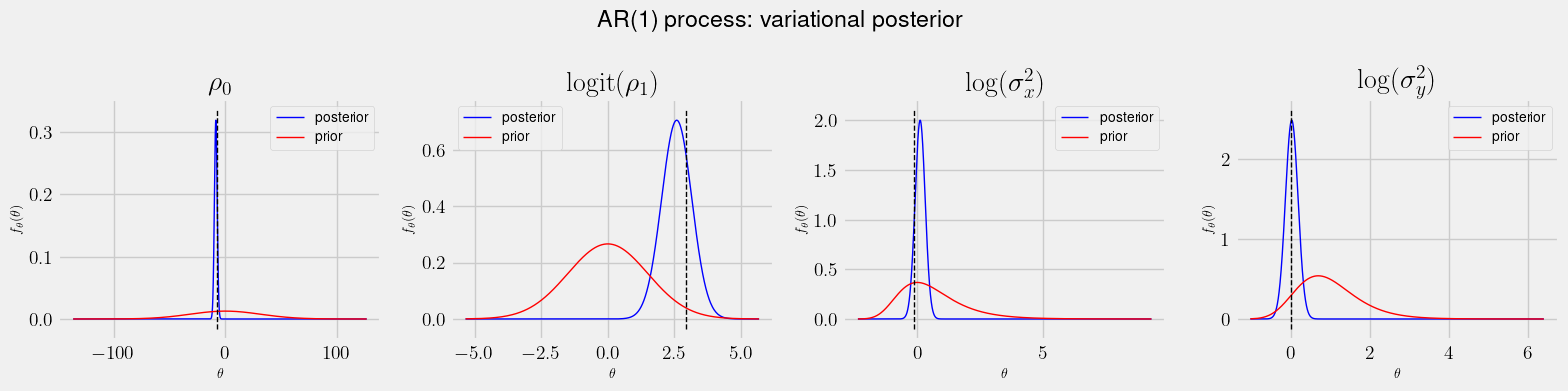

In [27]:
# theta = torch.tensor([[-7.22, 0.9, 0.8866, 1]])
# theta_transformed = theta.clone()
# theta_transformed[...,1] = (1 + theta_transformed[...,1]).log() -  (1 - theta_transformed[...,1]).log()
# theta_transformed[...,2:].log_()

# #theta, theta_transformed = prior.sample((1,))
# T = n_obs-1

# y = AR1(theta, T)
# y = transform_data(y, period_length=period_length)

# run the gmmnet
with torch.no_grad():
    mean, chol, coeff = gmmnet(y.to(device))

n_sim, n_component, dim = mean.shape[0], mean.shape[1], mean.shape[2]

# calculate Cholesky factors
chol = torch.vmap(lf.exp_diagonal)(lf.to_triangular(chol.view(n_sim * n_component,  dim * (dim + 1) // 2), dim)).view(n_sim, n_component, dim, dim)

# # caclulate precision matrices
precision = chol @ chol.transpose(2, 3)

# # calculate covariance matrices
covariance = torch.linalg.inv(precision) 

# mixture weights
mix = D.Categorical(coeff)

N = 10000
# prior values
_, prior_vals = prior.sample((N,))

# plotting
fig = plt.figure(figsize=(16, 4))

for k in range(dim):
    # mixture components
    comp = D.Normal(loc=mean[:,:,k], scale=torch.sqrt(covariance[:,:,k,k]))
    # define the mixture
    gmm = D.MixtureSameFamily(mix, comp) if n_component > 1 else D.Normal(mean[:,:,k].squeeze(), torch.sqrt(covariance[:,:,k,k]).squeeze())
    
    # prior values
    theta_k_prior = prior_vals[...,k].sort().values
    theta_k_sd = (theta_k_prior - mean_param[k]) / std_param[k]  # standardize parameters

    # posterior pdf
    pdf_posterior = gmm.log_prob(theta_k_sd.to(device)).exp().cpu() / std_param[k]
        
    # true value
    theta_k_true = theta_transformed[:,k]

    # prior pdf
    if k == 0:
        pdf_prior = prior.rho0.log_prob(theta_k_prior).exp() 
    elif k == 1:
        pdf_prior = prior.logitrho1.log_prob(theta_k_prior).exp()
    elif k == 2:
        theta_inv = theta_k_prior.exp()
        pdf_prior = prior.sigma2_x.log_prob(theta_inv).exp() * abs(theta_inv)
    elif k == 3:
        theta_inv = theta_k_prior.exp()
        pdf_prior = prior.sigma2_y.log_prob(theta_inv).exp() * abs(theta_inv)
    
    
    fig.add_subplot(1, dim, k+1)
    if k==0:
        plt.plot(theta_k_prior, pdf_posterior, lw=1., c='b', label='posterior')
        plt.plot(theta_k_prior, pdf_prior, lw=1., c='r', label='prior')
        #plt.xlim((- 2*abs(theta_k_true)-1.5,  2*abs(theta_k_true)+1.5))
        #plt.xlim((-15,-5))
    elif k==1:
        plt.plot(theta_k_prior, pdf_posterior, lw=1., c='b', label='posterior')
        plt.plot(theta_k_prior, pdf_prior, lw=1., c='r', label='prior')
        #plt.xlim((1,4.5))
    elif k==2:
        plt.plot(theta_k_prior, pdf_posterior, lw=1., c='b', label='posterior')
        plt.plot(theta_k_prior, pdf_prior, lw=1., c='r', label='prior')
        #plt.xlim((-1,1))
    else:
        plt.plot(theta_k_prior, pdf_posterior, lw=1., c='b', label='posterior')
        plt.plot(theta_k_prior, pdf_prior, lw=1., c='r', label='prior')
        #plt.xlim((-0.5,0.8))

    plt.vlines(x=theta_k_true, ymin=plt.axis()[2], ymax=plt.axis()[3], linestyles='dashed', colors='black', lw=1)
    
    plt.xlabel(r'$\theta$', fontsize=10)
    plt.ylabel(r'$f_\theta(\theta)$', fontsize=10)
    plt.legend(fontsize=10)
    plt.title(labels[k])

plt.suptitle('AR(1) process: variational posterior')
plt.tight_layout()
plt.show()

### Simulation-based calibration check

In [28]:
def sbc_gaussian(gmmnet, proposal, n_sim = 1e+4, ecdf=True, ecdf_diff=False, logscale=None, labels=None):
    '''
    Perform simulation-based calibration check for a Gaussian mixture network for posterior approximation

    Input:
        -- gmmnet: Gaussian mixture network, with input size given by `sample_size`
        -- proposal: proposal distribution `theta ~ p(theta)`, usually the same as the prior/proposal distribution used for training
                     Note: must have a `sample()` method
        
        -- generator: function that takes parameter values `theta` as input and generate the corresponding simulator model
                       `x ~ p(x|theta)`  as an instance of a class with a `sample` method
        
        -- sample_size: number of iid samples from `x ~ p(x|theta)` for each values of theta

        -- n_sim: number of simulation from the joint distribution: theta ~ p(theta); x ~ p(x|theta)

        -- ecdf: whether to output an eCDF or a histogram plot, default: ecdf=True

        -- ecdf_diff: whether on the y-axis are the `ecdf(w)` values (if True) or `ecdf(w) - w` values (if False).
                        This is ignored if ecdf=False.
        
        -- logscale: (iterable) contains dimensions of the model parameter vector `theta` that are on log-scale
                        note: we use the standard Python counting, starting at 0

    Note: 95% confidence intervals are based on the  Dvoretzky–Kiefer–Wolfowitz inequality (see https://en.wikipedia.org/wiki/Empirical_distribution_function, accessed: 20-05-2024)
    
    Output: SBC plot as a Pyplot figure
    '''
    # draw samples from the prior/proposal  theta ~ p(theta)
    Theta, _ = proposal.sample((n_sim,))

    # draw samples from the model x ~ p(x|theta)
    X = AR1(Theta, n_obs)
    X = transform_data(X, period_length=period_length)
    # ensure all dimensions are on the right scale
    Theta[:,1] = (1 + Theta[:,1]).log() - (1 - Theta[:,1]).log()

    if logscale:
        for i in logscale:
            Theta[:,i] = Theta[:,i].log()     # put sigma2 on logscale
    
    # run the gmmnet
    with torch.no_grad():
        mean, chol, coeff = gmmnet(X.to(device))

    n_component, dim = mean.shape[1], mean.shape[2]

    # calculate Cholesky factors
    chol = torch.vmap(lf.exp_diagonal)(lf.to_triangular(chol.view(n_sim * n_component,  dim * (dim + 1) // 2), dim)).view(n_sim, n_component, dim, dim)

    # caclulate precision matrices
    precision = chol @ chol.transpose(2, 3)

    # calculate covariance matrices
    covariance = torch.linalg.inv(precision) 

    # define GMM variational marginal distributions and calculate cdf values for the true parameter values
    
    fig = plt.figure(figsize=(12, 3))

    for j in range(dim):
        # mixture weights
        mix = D.Categorical(coeff)
        # mixture components
        comp = D.Normal(mean[:,:,j], torch.sqrt(covariance[:,:,j,j]))
        # define the mixture
        gmm = D.MixtureSameFamily(mix, comp) if n_component > 1 else D.Normal(mean[:,:,j].squeeze(), torch.sqrt(covariance[:,:,j,j]).squeeze())
        # evaluate cdf
        w = gmm.cdf(Theta[:,j].to(device)).cpu().squeeze()

        if ecdf:
            #=====================================================
            # ECDF plot
            #=====================================================
            # Calculate the empirical cumulative distribution function (ECDF)
            eCDF = torch.arange(1, n_sim + 1) / n_sim

            # calculate 95% confidence intervals for the eCDF
            eps = np.sqrt(np.log(2 / 0.05) / (2 * n_sim))
            eCDF_lower, eCDF_upper = eCDF - eps, eCDF + eps

            # exact cdf
            x = np.linspace(0, 1, 100)
            w = w.sort().values

            fig.add_subplot(1, dim, j+1)
            if not ecdf_diff:
                # plot eCDF and true CDF values
                plt.step(w, eCDF, lw=1)
                plt.plot(x, x, 'k--', lw=1)
                # plot 95% confidence bands
                plt.fill_between(w, eCDF_lower, eCDF_upper, color='red', alpha=0.2)
                plt.ylabel(r'$F_{\omega}$')
            else:
                plt.step(w, eCDF - w, lw=1)
                #plt.fill_between(w, eCDF_lower - w, eCDF_upper - w, color='red', alpha=0.1)
                plt.ylabel(r'$F_{\omega} - \omega$')

            plt.xlabel(r'$\omega$')
            plt.title(labels[j])
        else:
            #========================================
            # plot histograms
            #========================================
            fig.add_subplot(1, dim, j + 1)
            plt.hist(w, bins=25, density=True, alpha=.6)
            plt.title(labels[j])

    plt.tight_layout()
        
    
    return fig

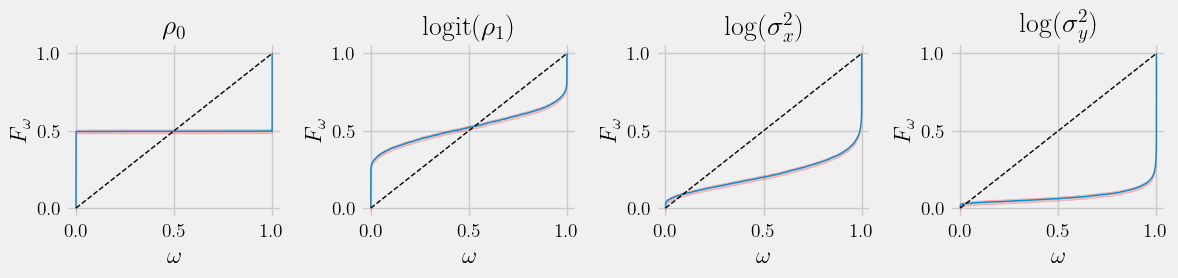

In [29]:
f = sbc_gaussian(gmmnet, prior, 10000, ecdf=True, ecdf_diff=False, logscale=[2,3], labels=labels)